In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import scipy.stats as stats
import soundfile as sf
import librosa 
from collections import defaultdict
import seaborn as sns
import scipy.stats as stats



In [2]:
with open('Features/Features.pickle','rb') as file:
    DF=pickle.load(file)
    
for i in range(193):
    vector=[]
    for j in range(len(DF)):
        vector.append(DF.iloc[j,2][i])
    vector=np.array(vector)
    DF[i]=vector

DF=DF.drop('FeatureVector',axis=1)
DF.head()

,label,ID,0,1,2,3,4,5,6,7,...,183,184,185,186,187,188,189,190,191,192
0,siren,0,-75.095718,129.611845,-32.669896,15.285440,-2.378206,14.626389,-3.764634,17.962046,...,13.581585,15.363748,15.579746,35.387735,-0.004255,0.014481,-0.040944,0.001575,-0.005375,0.005263
1,siren,1017,-529.822549,3.207651,-39.342830,-4.806191,-1.510516,11.538968,6.360950,0.175858,...,40.240238,39.600647,35.088244,39.409279,0.000226,-0.003061,-0.005560,0.049707,-0.004167,-0.008515
2,siren,1068,-321.691683,142.703895,-29.068545,19.488420,-2.804571,17.805163,4.255999,7.789272,...,24.381119,26.783475,24.162785,38.694912,0.025281,0.024722,-0.127286,-0.032569,-0.006869,0.021095
3,siren,1069,-251.963839,114.677643,-70.299636,-5.654069,-33.883682,21.279570,9.678297,9.592076,...,24.619884,26.538950,24.144203,38.025016,-0.009540,0.018023,-0.037589,0.059820,-0.017432,-0.004185
4,siren,1116,-341.286762,148.386037,-19.530048,12.357504,10.122546,25.564659,22.492980,11.057594,...,13.280341,15.284006,16.753369,29.313002,0.001852,0.002387,0.011851,0.003681,0.024676,-0.008621


In [5]:
DF.shape

(5435, 195)

In [7]:
DF=DF.sample(n=len(DF)) #we shuffle the data frame so we dont get chunks data with similar class.
DF.head()


,label,ID,0,1,2,3,4,5,6,7,...,183,184,185,186,187,188,189,190,191,192
3572,drilling,3459,-93.604630,53.792983,24.850721,2.481674,-6.618878,15.039431,-17.725997,13.145317,...,14.201751,15.330638,16.585992,35.239142,0.003201,0.016362,0.040827,0.008147,-0.006355,-0.015162
5178,engine_idling,5791,-226.136916,90.987329,-9.427117,-0.758044,-1.765651,8.907143,-4.451681,2.775345,...,14.499373,14.917280,14.887299,31.810821,-0.010275,-0.014379,-0.056187,0.008376,0.005219,-0.015223
2362,dog_bark,8382,-350.997488,167.984327,-19.633620,-27.341125,-10.514517,-28.088911,-39.121422,-20.836970,...,18.179906,21.881613,20.007374,33.420140,-0.004077,-0.000823,0.012293,-0.007651,-0.019498,0.001046
202,siren,3585,-492.739549,140.628001,-28.137953,14.006551,-15.302229,20.158710,5.318891,3.450800,...,20.720995,21.156674,20.683819,32.589278,-0.003551,0.012170,-0.020184,-0.013719,0.004488,0.001264
2538,jackhammer,2503,-90.994338,111.146245,-24.899062,9.462462,11.383995,9.167177,4.624107,0.776687,...,13.897881,16.667155,17.512857,32.275210,-0.005057,0.017089,0.045542,0.007716,-0.005931,-0.015916


In [15]:
X_train=DF.iloc[:,2:].values
Y_train=DF.iloc[:,0].values

## Methodology. 

Our training data set consists of 5435 samples. Each sample has 193 features. We train various algorithms and tune their parameters using k-fold cross-validation.

## we begin with the k-NN algorithm.

In [33]:
#For our first algorithm we try the k-NN algorithm. The only parameter here to be tuned is the k parameter.

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

NumFolds=10
N=[1,3,5,7,9,11,13] #potential values for K
scores=np.empty((len(N),NumFolds))

for i,n in enumerate(N):
    print(n)
    neigh = KNeighborsClassifier(n_neighbors=n)
    scores[i,:]=cross_val_score(neigh,X_train,Y_train,cv=NumFolds)
    


1
3
5
7
9
11
13


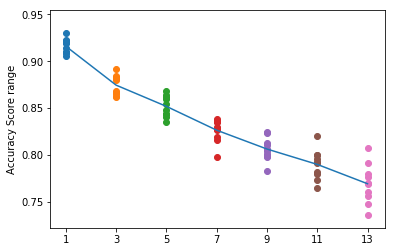

In [34]:
for i,n in enumerate(N):
    plt.scatter(n*np.ones(NumFolds),scores[i,:])


plt.plot(N,np.mean(scores,axis=1))
plt.xticks(N)

plt.xlabel('Hyperparameter K value')
plt.ylabel('Accuracy Score range')

plt.show()



From the above, it seems like the 1-neighbour classifier seems to generalize best. This is a bit of a weird results as we are getting the most complex model to generalize best. Should look more into it.

## next we try the linear SVM algorithm, with hyperparameter C

Large values of C increase regularization which should increase "generalizability". Low values of C should tend to over-fit the model.

In [36]:
from sklearn.svm import LinearSVC

NumFolds=10
C=[0.0001,0.1,1,10,100]
scores=np.empty((len(C),NumFolds))

for i,c in enumerate(C):
    print(c)
    clf = LinearSVC(dual=False,C=c)
    scores[i,:]=cross_val_score(clf,X_train[:1000],Y_train[:1000],cv=NumFolds)

    




0.0001
0.1
1
10
100


Above, we only ran the cross-validation with 1000 out of the 5435 samples due to long runtime. The above scheme will be re-run on the entire data.

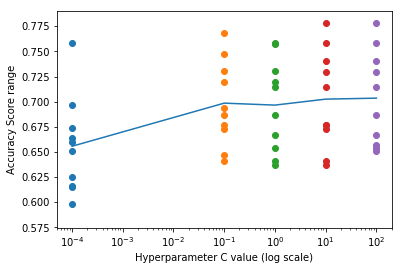

In [41]:
for i,c in enumerate(C):
    plt.scatter(c*np.ones(NumFolds),scores[i,:])


plt.plot(C,np.mean(scores,axis=1))
plt.xticks(C)
plt.semilogx()
plt.xlabel('Hyperparameter C value (log scale)')
plt.ylabel('Accuracy Score range')

plt.show()


Out of curiousity we try the same as above but with the L1 norm used for penalization instead (L2 is used by default)

In [42]:
from sklearn.svm import LinearSVC

NumFolds=10
C=[0.0001,0.1,1,10,100]
scores=np.empty((len(C),NumFolds))

for i,c in enumerate(C):
    print(c)
    clf = LinearSVC(penalty='l1',dual=False,C=c)
    scores[i,:]=cross_val_score(clf,X_train[:1000],Y_train[:1000],cv=NumFolds)

    



0.0001
0.1
1
10
100


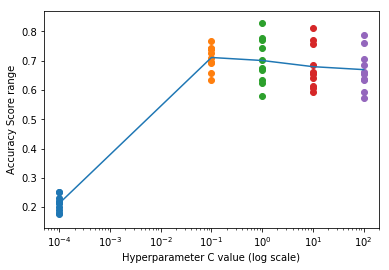

In [43]:
for i,c in enumerate(C):
    plt.scatter(c*np.ones(NumFolds),scores[i,:])


plt.plot(C,np.mean(scores,axis=1))
plt.xticks(C)
plt.semilogx()
plt.xlabel('Hyperparameter C value (log scale)')
plt.ylabel('Accuracy Score range')

plt.show()

